# Exercise 2c BIG model response to change in insulin sensitivity

In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

### Simulate the BIG model response to change in insulin sensitivity over period of months:

#### We start by writing the model's equations

In [2]:
m,s,I,G,q,B,gamma,G0,p = symbols('m,s,I,G,q,B,gamma,G_0,p',positive=True)

dG    = m     - s*I*G
dI    = B*q*G - gamma*I
dB    = B*p*(G-G0)

#### We want to simulate what happens if insulin sensitivity suddenly drops
We will simulate the model for 200 days

We will use the following parameters: $m=1,G_0=1,q=1,\gamma=1,p=0.003$. $p$ sets the turnover rate of beta-cells which is much slower insulin

We will simulate that $s$ suddenly drops by 50%:
prior to the change in $s$, the system was at steady state:
* Use $s=1$ to calculate the steady state, this steady state is the inital condition of the simulation
* Use $s=0.5$ to simulate the model



### Follow the code below:

#### When we are simulating two processes with major difference in timescale, Euler method becomes either slow or inaccurate.
#### We use a different method to integrate the ODEs, using scipy's 'odeint' function (ordinary differntial equation integrator)

#### Before we dive in to the code of the simualtion, lets get familiar with two new sympy functions: 'Matrix' and 'lambdify'

We use 'Matrix' in order to hold all three equations in one variable

In [3]:
model      = Matrix([dG,dI,dB])
display(model)

Matrix([
[     -G*I*s + m],
[B*G*q - I*gamma],
[  B*p*(G - G_0)]])

We store values for the parameters within a dictionary


In [4]:
ic_pars    = {gamma:1,m:1,q:1,p:0.003,G0:1,s:1} 
sim_pars   = {gamma:1,m:1,q:1,p:0.003,G0:1,s:0.5} 

We use '.subs()' in order to substitute the parameters with the numerical values:

In [5]:
display(model.subs(ic_pars))

Matrix([
[       -G*I + 1],
[        B*G - I],
[0.003*B*(G - 1)]])

We use solve in order to find the steady state.

Because we gave numercial values for the parameters, the steady state will also be numeric

We will use this steady state as the intial condition

In [6]:
ic   = solve(model.subs(ic_pars),[G,I,B])[0]
print('The inital condition is:')
print(ic)

The inital condition is:
(1.00000000000000, 1.00000000000000, 1.00000000000000)


#### Great! we now have the inital conditions for our simualtion.
#### Note that we never explicity wrote down the steady state. we used sympy all the way to get it from the parameters and the differntial equations

### Next, we want a method to calulate $(dG,dI,dB)$ for a given set of parameter $(G,I,B)$

we can use '.subs()' in order to calculate the differential equations

For example, if G=2, I=1, B=1, we can find dG,dI,dB:

In [7]:
display(model.subs(sim_pars).subs({G:2,I:1,B:1}))

Matrix([
[    0],
[    1],
[0.003]])

#### However, there is a better way: 'lambdify'

lambdify takes our symbolic model and returns a python function:

* The first argument is a list of the parameters that we want to use as input for the function
* The second argument is a symbolic expression to turn into a function

In the following example, we use lambdify in order to make a function 'func' that substracts 5 from a number:
* $G - 5$ is the mathematical expression
* $G$ is the input for the function

In [8]:
func = lambdify(G,G-5)

When we pass 'func' the input $7$, it will return the solution of $G-5$ for $G=7$.

In [9]:
func(7)

2

'lambdify' can get more than one parameter, for example:

In [10]:
func = lambdify([G,I],G-I)

When we pass 'func' the inputs $7,2$, it will return the solution of $G-I$ for $G=7,I=2$.

In [11]:
func(7,2)

5

In addition, 'lambdify' can get more than expression:

In [12]:
func = lambdify([G,I],[G-I,G+I])

When we pass 'func' the inputs $7,2$, it will return two solution. The first is for $G-I$, the sconde is for $G+I$

In [13]:
func(7,2)

[5, 9]

### Now we are ready to use 'lambdify' to calulate $(dG,dI,dB)$ for a given set of parameter $(G,I,B)$

'model.subs(sim_pars)' holds three symbolic expressions (𝑑𝐺,𝑑𝐼,𝑑𝐵) with numeric values for the parameters

In [14]:
display(model.subs(sim_pars))

Matrix([
[   -0.5*G*I + 1],
[        B*G - I],
[0.003*B*(G - 1)]])

In [15]:
model_func = lambdify([G,I,B],model.subs(sim_pars))

For example, if G=2, I=1, B=1, We can find dG,dI,dB:

In [16]:
model_func(2,1,1)

array([[0.   ],
       [1.   ],
       [0.003]])

usually we add '.flat[:]' to get the result in a 1-d array:

In [17]:
model_func(2,1,1).flat[:]

array([0.   , 1.   , 0.003])

#### Altough it seems that we can get the same results with .subs() and lambdify,  using lambdify is much faster. But more importently, it enables us to pass our model into other python libraries.

### Now we will see how to use lambdify in order to simulate the model:
#### We build a simulation function around 'model_func'

The simulation function must have the following form:

First input  - list of the variables in the model $(G,I,B)$

Second input - time $t$

Returns      - list of the calculated change in each variable per $dt$ $(dG,dI,dB)$

#### A generic form for this function is:

In [18]:
def sim(y,t):
    G,I,B    = y                         # y is the list of the varibales
    dG,dI,dB = model_func(G,I,B).flat[:]
    return dG,dI,dB 

#### Like before, we start by defining the time-course of the simualtion

In [19]:
sim_length = 200*24  # 200 days
dt         = 1       # one hour
sim_time   = np.arange(0,sim_length,dt)

To simulate the model, we use 'odeint' (ordinary differntial equation integrator)

In [20]:
from scipy.integrate import odeint

'odeint' gets the simulation function, the intial conditions and the time-course

In [21]:
result = odeint(sim,ic,sim_time)

I store the simulation result in pandas DataFrame because we can plot it easly

In [22]:
import pandas as pd

<AxesSubplot:>

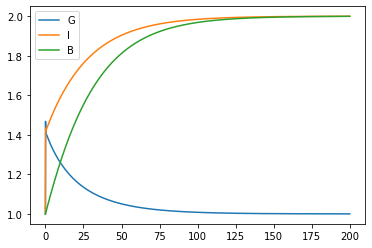

In [23]:
result = pd.DataFrame(result,columns=['G','I','B'],index=sim_time/24)
result.plot()

#  ** deep sigh of relief  **
# 
# 
# 
# 
# 
# 
# 
# 

### Together these steps look like this:

<AxesSubplot:>

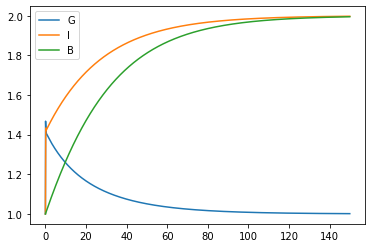

In [24]:
ic_pars    = {gamma:1,m:1,q:1,p:0.003,G0:1,s:1} 
sim_pars   = {gamma:1,m:1,q:1,p:0.003,G0:1,s:0.5} 

model      = Matrix([dG,dI,dB])
ic         = solve(model.subs(ic_pars),[G,I,B])[0]
model_func = lambdify([G,I,B],model.subs(sim_pars))

def sim(y,t):
    G,I,B    = y
    dG,dI,dB = model_func(G,I,B).flat[:]
    return dG,dI,dB 

sim_length = 150*24  # 200 days
dt         = 1       # one hour
sim_time   = np.arange(0,sim_length,dt)
result     = pd.DataFrame(odeint(sim,ic,sim_time),columns=['G','I','B'],index=sim_time/(24))

result.plot()

# 
# 

### Simulate a drop in insulin sensitivity and three glucose tolerance tests:
1. GTT before insulin sensitivity dropped.
2. GTT shortly after sensitivity dropped.
3. GTT long after sensitivity dropped.

#### Use the provided functions 'get_m', get_s'  - they  will provide values $m$ and $s$ at different times:
* For the first 50 days, insulin sensitivity $s=1$
* at day 50, insulin sensitivity drops $s=0.2$
* In addition, we give three 1-hour pulses of glucose. at days 10, 60 and 150
* When using lambdify, the list of parameter to use as input should includ $m$ and $s$ - they are subject to change during the simualtion
* When passing dictionary of parameter values, exclude $s,m$ - they are subject to change during the simualtion
* When calculating the intial condition, use $m=1,s=1$

Plot the simulation

In [25]:
def get_m(t):
    
    t = np.ceil(t)
    
    if ((t >= 10*24) & (t <= 10*24 + 1)):
        m = 2  
    elif ((t >= 60*24) & (t <= 60*24 + 1)):
        m = 2  
    elif ((t >= 150*24) & (t <= 150*24 + 1)):
        m = 2    
    else:
        m = 1
        
    return m

def get_s(t):
    
    t = np.ceil(t)
    
    if t/24 > 50: # insulin sensitivity drops at day 50
        s = 0.2
    else:
        s = 1     
    return s

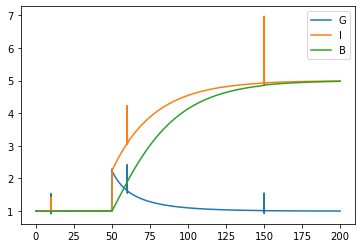

In [26]:
pars       = {gamma:1,q:1,p:0.003,G0:1}
model      = Matrix([dG,dI,dB]).subs(pars)
ic         = solve(model.subs(s,1).subs(m,1),[G,I,B])[0]
model_func = lambdify([G,I,B,s,m],model)

def sim(y,t):
    m        = get_m(t)
    s        = get_s(t)
    G,I,B    = y
    dG,dI,dB = model_func(G,I,B,s,m).flat[:]
    return dG,dI,dB 

sim_length = 200*24    # 200 days
dt         = 1/60      # one minute
sim_time   = np.arange(0,sim_length,dt)
res        = pd.DataFrame(odeint(sim,ic,sim_time,tcrit=[24*10,24*60,24*150]),columns=['G','I','B'],index=sim_time/24)
res.plot(); plt.show()

### Using 'plot_GTTs' plot and observe the response to each GTT

In [27]:
def plot_GTTs(res):
    plt.figure(figsize=(12,4))
    ax1  = plt.subplot(121)
    g10  = res.loc[9.5:10.5].G.values
    g60  = res.loc[59.5:60.5].G.values
    g150 = res.loc[149.5:150.5].G.values
    ax1.plot(g10)
    ax1.plot(g60)
    ax1.plot(g150)
    ax1.set_ylabel('Glucose')
    ax1.set_xlabel('time')
    ax1.legend(['day 10', 'day 60', 'day 150'])
    
    ax2  = plt.subplot(122)
    i10  = res.loc[9.5:10.5].I.values
    i60  = res.loc[59.5:60.5].I.values
    i150 = res.loc[149.5:150.5].I.values
    ax2.plot(i10)
    ax2.plot(i60)
    ax2.plot(i150)
    ax2.set_ylabel('Insulin')
    ax2.set_xlabel('time')
    ax2.legend(['day 10', 'day 60', 'day 150'])
    plt.tight_layout(); plt.show()

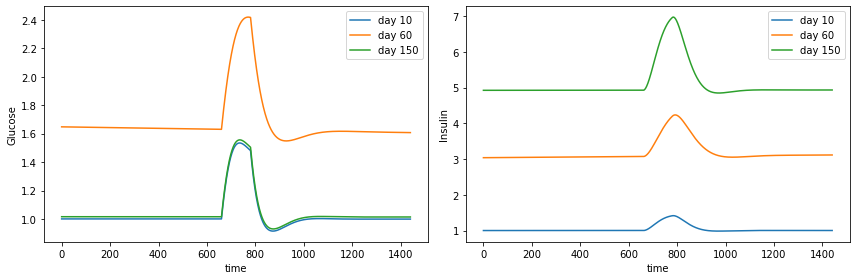

In [28]:
plot_GTTs(res)